# Advanced Fraud Detection System


 ## Project Overview

 - **Primary Objective**: Reduce fraudulent transactions by 15%
 - **Secondary Objective**: Reduce false positives by 25%
 - **Tertiary Objective**: Deliver actionable insights on customer behavior
 
 ### Project Phases:

 1. Discovery & Preparation (EDA + Feature Engineering)
 2. Model Development & Evaluation (MLflow tracking)
 3. Insights & Handover (SHAP interpretation + FastAPI deployment)



### Setup and Imports

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, accuracy_score,
                             precision_score, recall_score, silhouette_score)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# SHAP for interpretation
import shap

# Serialization
import pickle
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Phase 1: Discovery & Preparation
#### 1.1 Data Loading

In [2]:
# Load all datasets
print("Loading datasets...")

customer_info = pd.read_csv('../raw/customer_info.csv')
fraudulent_patterns = pd.read_csv('../raw/fraudulent_patterns.csv')
merchant_info = pd.read_csv('../raw/merchant_info.csv')
transaction_patterns = pd.read_csv('../raw/transaction_patterns.csv')
transactions = pd.read_csv('../raw/transactions.csv')
transaction_flags = pd.read_csv('../raw/transactions_flags.csv')

print(f"✓ Loaded {len(customer_info)} customers")
print(f"✓ Loaded {len(transactions)} transactions")
print(f"✓ Loaded {len(merchant_info)} merchants")
print(f"✓ Loaded {len(fraudulent_patterns)} fraud patterns")
print(f"✓ Loaded {len(transaction_flags)} transaction flags")
print(f"✓ Loaded {len(transaction_patterns)} transaction patterns")


Loading datasets...
✓ Loaded 80 customers
✓ Loaded 60 transactions
✓ Loaded 120 merchants
✓ Loaded 15 fraud patterns
✓ Loaded 60 transaction flags
✓ Loaded 57 transaction patterns


In [3]:
# view the first 2 rows of each dataframe
print("Preview of datasets:")
print("\nCustomer Info:")
print(customer_info.head(2))
print("\nTransactions:")
print(transactions.head(2))
print("\nMerchant Info:")
print(merchant_info.head(2))
print("\nTransaction Patterns:")
print(transaction_patterns.head(2))
print("\nTransaction Flags:")
print(transaction_flags.head(2))


Preview of datasets:

Customer Info:
   CUSTOMER_ID FIRST_NAME LAST_NAME              REGION        CITY  \
0           34       Kofi    Mensah  Greater Manchester  Manchester   
1            5      Kwame   Asamoah  Greater Manchester  Manchester   

  ACCOUNT_STATUS ACCOUNT_TYPE             DATE_CREATED  
0         Active     Checking  2023-07-12 14:45:00.000  
1         Active     Checking  2023-01-18 13:45:00.000  

Transactions:
   TRANSACTION_ID  CUSTOMER_ID  MERCHANT_ID         TRANSACTION_DATE  \
0               1            3            7  2023-06-15 09:00:00.000   
1               2            5           12  2023-06-16 14:15:00.000   

  TRANSACTION_TYPE  AMOUNT TRANSACTION_STATUS  \
0            Debit  150.75          Completed   
1           Credit  120.00          Completed   

                     TRANSACTION_ADDRESS TRANSACTION_CITY  TRANSACTION_REGION  \
0  123 Market Street, Manchester, M1 2AB       Manchester  Greater Manchester   
1     45 Oxford Road, Manchester, M2

#### 1.2 Advanced Exploratory Data Analysis (EDA)


=== Dataset Shapes ===
Customers: (80, 8)
Transactions: (60, 13)
Merchants: (120, 7)
Flags: (60, 6)

=== Missing Values Analysis ===
Customers: No missing values
Transactions: No missing values
Merchants: No missing values
Flags: No missing values

=== Fraud Distribution ===
Non-Fraud: 33 (55.00%)
Fraud: 27 (45.00%)
Imbalance Ratio: 1:1.2


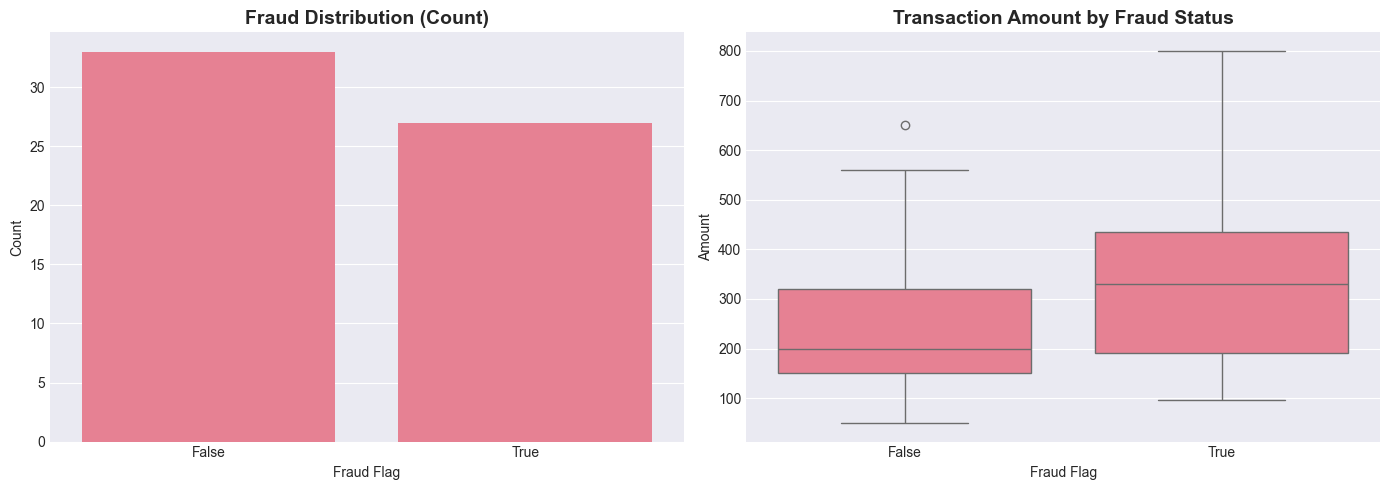

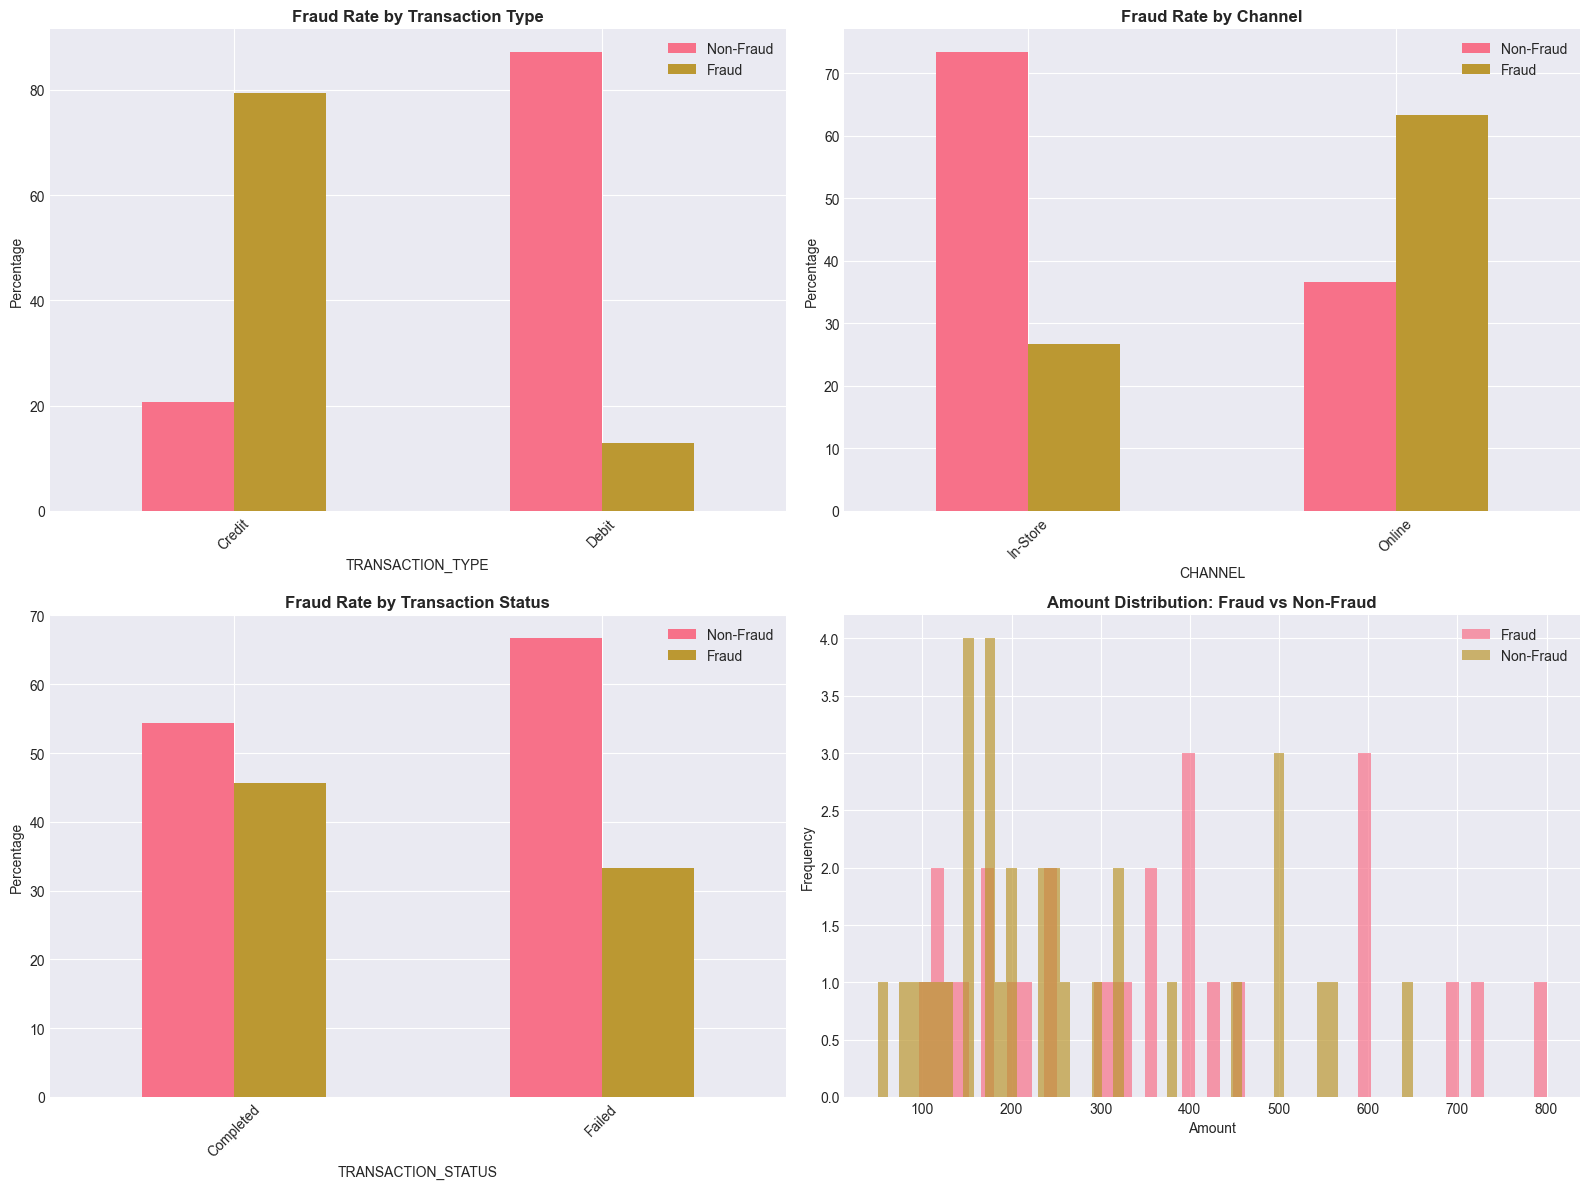

In [4]:
# %%
# Display dataset shapes and basic info
print("\n=== Dataset Shapes ===")
for name, df in [('Customers', customer_info), ('Transactions', transactions), 
                  ('Merchants', merchant_info), ('Flags', transaction_flags)]:
    print(f"{name}: {df.shape}")

# %%
# Check for missing values
print("\n=== Missing Values Analysis ===")
for name, df in [('Customers', customer_info), ('Transactions', transactions), 
                  ('Merchants', merchant_info), ('Flags', transaction_flags)]:
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name}:")
        print(missing[missing > 0])
    else:
        print(f"{name}: No missing values")

# %%
# Fraud Distribution Analysis
print("\n=== Fraud Distribution ===")
fraud_dist = transactions['FRAUD_FLAG'].value_counts()
fraud_pct = transactions['FRAUD_FLAG'].value_counts(normalize=True) * 100

print(f"Non-Fraud: {fraud_dist[False]} ({fraud_pct[False]:.2f}%)")
print(f"Fraud: {fraud_dist[True]} ({fraud_pct[True]:.2f}%)")
print(f"Imbalance Ratio: 1:{fraud_dist[False]/fraud_dist[True]:.1f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=transactions, x='FRAUD_FLAG', ax=axes[0])
axes[0].set_title('Fraud Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fraud Flag')
axes[0].set_ylabel('Count')

# Transaction amount by fraud status
sns.boxplot(data=transactions, x='FRAUD_FLAG', y='AMOUNT', ax=axes[1])
axes[1].set_title('Transaction Amount by Fraud Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fraud Flag')
axes[1].set_ylabel('Amount')
plt.tight_layout()
plt.show()

# %%
# Transaction Type and Channel Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Transaction Type
trans_type_fraud = pd.crosstab(transactions['TRANSACTION_TYPE'], 
                                transactions['FRAUD_FLAG'], normalize='index') * 100
trans_type_fraud.plot(kind='bar', ax=axes[0, 0], rot=45)
axes[0, 0].set_title('Fraud Rate by Transaction Type', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].legend(['Non-Fraud', 'Fraud'])

# Channel
channel_fraud = pd.crosstab(transactions['CHANNEL'], 
                             transactions['FRAUD_FLAG'], normalize='index') * 100
channel_fraud.plot(kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Fraud Rate by Channel', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(['Non-Fraud', 'Fraud'])

# Transaction Status
status_fraud = pd.crosstab(transactions['TRANSACTION_STATUS'], 
                            transactions['FRAUD_FLAG'], normalize='index') * 100
status_fraud.plot(kind='bar', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('Fraud Rate by Transaction Status', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(['Non-Fraud', 'Fraud'])

# Amount Distribution
transactions[transactions['FRAUD_FLAG'] == True]['AMOUNT'].hist(bins=50, 
                                                                  ax=axes[1, 1], 
                                                                  alpha=0.7, 
                                                                  label='Fraud')
transactions[transactions['FRAUD_FLAG'] == False]['AMOUNT'].hist(bins=50, 
                                                                   ax=axes[1, 1], 
                                                                   alpha=0.7, 
                                                                   label='Non-Fraud')
axes[1, 1].set_title('Amount Distribution: Fraud vs Non-Fraud', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Amount')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

#### 1.3 Advanced Feature Engineering


In [5]:
# %%
# Merge all datasets
print("Merging datasets...")

# Main transaction dataset
df = transactions.copy()

# Merge customer info
df = df.merge(customer_info, on='CUSTOMER_ID', how='left')

# Merge merchant info
df = df.merge(merchant_info, on='MERCHANT_ID', how='left')

# Merge transaction patterns
df = df.merge(transaction_patterns, on='TRANSACTION_ID', how='left')

# Merge fraudulent patterns (through pattern_id)
df = df.merge(fraudulent_patterns, on='PATTERN_ID', how='left')

# Merge transaction flags
df = df.merge(transaction_flags, on='TRANSACTION_ID', how='left')

print(f"✓ Merged dataset shape: {df.shape}")

# %%
# Parse dates (handle various formats)
def parse_date_flexible(date_str):
    """Parse dates in various formats"""
    if pd.isna(date_str):
        return pd.NaT
    
    try:
        # Try standard formats
        return pd.to_datetime(date_str)
    except:
        try:
            # Handle time-only format (assuming current date)
            if ':' in str(date_str) and len(str(date_str).split(':')) >= 2:
                return pd.to_datetime('2024-01-01 ' + str(date_str))
        except:
            pass
    return pd.NaT

df['TRANSACTION_DATE'] = df['TRANSACTION_DATE'].apply(parse_date_flexible)
df['DATE_CREATED'] = df['DATE_CREATED'].apply(parse_date_flexible)
df['FLAG_DATE'] = df['FLAG_DATE'].apply(parse_date_flexible)

# Fill NaT with median or most recent date
df['TRANSACTION_DATE'].fillna(df['TRANSACTION_DATE'].mode()[0], inplace=True)
df['DATE_CREATED'].fillna(df['DATE_CREATED'].mode()[0], inplace=True)

print("✓ Dates parsed successfully")

# %%
# Feature Engineering: Temporal Features
print("Creating temporal features...")

df['transaction_hour'] = df['TRANSACTION_DATE'].dt.hour
df['transaction_day'] = df['TRANSACTION_DATE'].dt.day
df['transaction_month'] = df['TRANSACTION_DATE'].dt.month
df['transaction_dayofweek'] = df['TRANSACTION_DATE'].dt.dayofweek
df['transaction_is_weekend'] = df['transaction_dayofweek'].isin([5, 6]).astype(int)

# Time since account creation
df['days_since_account_created'] = (df['TRANSACTION_DATE'] - df['DATE_CREATED']).dt.days
df['days_since_account_created'].fillna(df['days_since_account_created'].median(), inplace=True)

# Time-based risk (late night transactions are riskier)
df['is_late_night'] = df['transaction_hour'].between(22, 5).astype(int)
df['is_business_hours'] = df['transaction_hour'].between(9, 17).astype(int)

print("✓ Temporal features created")

# %%
# Feature Engineering: Customer Behavior Metrics
print("Creating customer behavior features...")

# Transaction velocity by customer
customer_metrics = df.groupby('CUSTOMER_ID').agg({
    'TRANSACTION_ID': 'count',
    'AMOUNT': ['sum', 'mean', 'std', 'min', 'max'],
    'FRAUD_FLAG': 'sum'
}).reset_index()

customer_metrics.columns = ['CUSTOMER_ID', 'customer_transaction_count', 
                             'customer_total_amount', 'customer_avg_amount', 
                             'customer_std_amount', 'customer_min_amount', 
                             'customer_max_amount', 'customer_fraud_count']

# Handle missing std
customer_metrics['customer_std_amount'].fillna(0, inplace=True)

# Customer fraud rate
customer_metrics['customer_fraud_rate'] = (
    customer_metrics['customer_fraud_count'] / customer_metrics['customer_transaction_count']
)

# Merge back
df = df.merge(customer_metrics, on='CUSTOMER_ID', how='left')

# Amount deviation from customer average
df['amount_deviation_from_avg'] = np.abs(df['AMOUNT'] - df['customer_avg_amount'])
df['amount_ratio_to_avg'] = df['AMOUNT'] / (df['customer_avg_amount'] + 0.01)

print("✓ Customer behavior features created")

# %%
# Feature Engineering: Merchant Risk Scores
print("Creating merchant risk features...")

# Merchant metrics
merchant_metrics = df.groupby('MERCHANT_ID').agg({
    'TRANSACTION_ID': 'count',
    'AMOUNT': ['mean', 'std'],
    'FRAUD_FLAG': ['sum', 'mean']
}).reset_index()

merchant_metrics.columns = ['MERCHANT_ID', 'merchant_transaction_count', 
                             'merchant_avg_amount', 'merchant_std_amount',
                             'merchant_fraud_count', 'merchant_fraud_rate']

merchant_metrics['merchant_std_amount'].fillna(0, inplace=True)

# Merchant risk score (based on fraud rate and volume)
merchant_metrics['merchant_risk_score'] = (
    merchant_metrics['merchant_fraud_rate'] * 
    np.log1p(merchant_metrics['merchant_transaction_count'])
)

# Merge back
df = df.merge(merchant_metrics, on='MERCHANT_ID', how='left')

print("✓ Merchant risk features created")

# %%
# Feature Engineering: Location-based Features
print("Creating location-based features...")

# Customer-Transaction location match
df['customer_merchant_same_city'] = (
    df['CITY'] == df['MERCHANT_CITY']
).astype(int)

df['customer_merchant_same_region'] = (
    df['REGION'] == df['MERCHANT_REGION']
).astype(int)

df['customer_transaction_same_city'] = (
    df['CITY'] == df['TRANSACTION_CITY']
).astype(int)

# Regional fraud rate
region_fraud_rate = df.groupby('TRANSACTION_REGION')['FRAUD_FLAG'].mean().to_dict()
df['region_fraud_rate'] = df['TRANSACTION_REGION'].map(region_fraud_rate)

print("✓ Location features created")

# %%
# Feature Engineering: Transaction Pattern Features
print("Creating transaction pattern features...")

# Transaction frequency (time between transactions for same customer)
df_sorted = df.sort_values(['CUSTOMER_ID', 'TRANSACTION_DATE'])
df_sorted['time_since_last_transaction'] = (
    df_sorted.groupby('CUSTOMER_ID')['TRANSACTION_DATE'].diff().dt.total_seconds() / 3600
)  # in hours
df_sorted['time_since_last_transaction'].fillna(999, inplace=True)

df = df_sorted

# High frequency indicator (< 1 hour)
df['is_high_frequency'] = (df['time_since_last_transaction'] < 1).astype(int)

# Device consistency
customer_device_count = df.groupby('CUSTOMER_ID')['TRANSACTION_DEVICE'].nunique().to_dict()
df['customer_device_count'] = df['CUSTOMER_ID'].map(customer_device_count)
df['is_new_device'] = (df['customer_device_count'] > 1).astype(int)

# Channel consistency
customer_channel_count = df.groupby('CUSTOMER_ID')['CHANNEL'].nunique().to_dict()
df['customer_channel_count'] = df['CUSTOMER_ID'].map(customer_channel_count)

print("✓ Transaction pattern features created")

# %%
# Feature Engineering: Relational & Aggregate Features
print("Creating relational features...")

# Amount percentile within customer history
df['amount_percentile'] = df.groupby('CUSTOMER_ID')['AMOUNT'].rank(pct=True)

# Transaction count by merchant category
merchant_category_count = df.groupby('MERCHANT_CATEGORY')['TRANSACTION_ID'].count().to_dict()
df['merchant_category_volume'] = df['MERCHANT_CATEGORY'].map(merchant_category_count)

# Flag-based features
df['has_location_flag'] = (df['FLAG_TYPE'] == 'Location-based Fraud').astype(int)
df['flag_resolved'] = df['RESOLVED'].fillna(False).astype(int)

print("✓ Relational features created")

# %%
# Severity level encoding
severity_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Critical': 4}
df['severity_level_encoded'] = df['SEVERITY_LEVEL'].map(severity_mapping).fillna(0)

# Pattern activity
df['pattern_is_active'] = df['IS_ACTIVE'].fillna(False).astype(int)

print(f"\n✓ Feature engineering complete! Total features: {df.shape[1]}")

# %%
# Display feature summary
print("\n=== Feature Engineering Summary ===")
feature_categories = {
    'Temporal': ['transaction_hour', 'transaction_day', 'transaction_month', 
                 'transaction_dayofweek', 'transaction_is_weekend', 
                 'days_since_account_created', 'is_late_night', 'is_business_hours'],
    'Customer Behavior': ['customer_transaction_count', 'customer_avg_amount', 
                          'customer_fraud_rate', 'amount_deviation_from_avg', 
                          'amount_ratio_to_avg'],
    'Merchant Risk': ['merchant_transaction_count', 'merchant_fraud_rate', 
                      'merchant_risk_score'],
    'Location': ['customer_merchant_same_city', 'customer_merchant_same_region', 
                 'region_fraud_rate'],
    'Transaction Patterns': ['time_since_last_transaction', 'is_high_frequency', 
                             'customer_device_count', 'is_new_device'],
    'Relational': ['amount_percentile', 'merchant_category_volume', 
                   'severity_level_encoded']
}

for category, features in feature_categories.items():
    available = [f for f in features if f in df.columns]
    print(f"{category}: {len(available)} features")
    
# Preview the new engineered dataset 
df.head()


Merging datasets...
✓ Merged dataset shape: (360, 36)
✓ Dates parsed successfully
Creating temporal features...
✓ Temporal features created
Creating customer behavior features...
✓ Customer behavior features created
Creating merchant risk features...
✓ Merchant risk features created
Creating location-based features...
✓ Location features created
Creating transaction pattern features...
✓ Transaction pattern features created
Creating relational features...
✓ Relational features created

✓ Feature engineering complete! Total features: 75

=== Feature Engineering Summary ===
Temporal: 8 features
Customer Behavior: 5 features
Merchant Risk: 3 features
Location: 3 features
Transaction Patterns: 4 features
Relational: 3 features


,TRANSACTION_ID,CUSTOMER_ID,MERCHANT_ID,TRANSACTION_DATE,TRANSACTION_TYPE,AMOUNT,TRANSACTION_STATUS,TRANSACTION_ADDRESS,TRANSACTION_CITY,TRANSACTION_REGION,CHANNEL,TRANSACTION_DEVICE,FRAUD_FLAG,FIRST_NAME,LAST_NAME,REGION,CITY,ACCOUNT_STATUS,ACCOUNT_TYPE,DATE_CREATED,MERCHANT_NAME,MERCHANT_TYPE,MERCHANT_ADDRESS,MERCHANT_REGION,MERCHANT_CITY,MERCHANT_CATEGORY,PATTERN_ID,PATTERN_NAME,PATTERN_DETAILS,SEVERITY_LEVEL,IS_ACTIVE,FLAG_ID,FLAG_TYPE,FLAG_REASON,FLAG_DATE,RESOLVED,transaction_hour,transaction_day,transaction_month,transaction_dayofweek,transaction_is_weekend,days_since_account_created,is_late_night,is_business_hours,customer_transaction_count,customer_total_amount,customer_avg_amount,customer_std_amount,customer_min_amount,customer_max_amount,customer_fraud_count,customer_fraud_rate,amount_deviation_from_avg,amount_ratio_to_avg,merchant_transaction_count,merchant_avg_amount,merchant_std_amount,merchant_fraud_count,merchant_fraud_rate,merchant_risk_score,customer_merchant_same_city,customer_merchant_same_region,customer_transaction_same_city,region_fraud_rate,time_since_last_transaction,is_high_frequency,customer_device_count,is_new_device,customer_channel_count,amount_percentile,merchant_category_volume,has_location_flag,flag_resolved,severity_level_encoded,pattern_is_active
126,22,1,7,2023-07-06 09:30:00,Debit,350.0,Completed,"123 Market Street, Manchester, M1 2AB",Manchester,Greater Manchester,In-Store,POS Terminal,True,Olivia,Smith,Greater Manchester,Manchester,Active,Checking,2023-03-05 14:00:00,Superdrug Manchester,Retail,"89 Arndale Centre, Manchester, M4 3AQ",Greater Manchester,Manchester,Pharmacy,10.0,Return Fraud,Fraudulent returns made by customers who purch...,Medium,True,22,Return Fraud,2023-07-06 16:40:00.000,NaT,False,9,6,7,3,0,122,0,1,6,2100.0,350.0,0.0,350.0,350.0,6,1.0,0.0,0.999971,18,250.25,83.70194,6,0.333333,0.98148,1,1,1,0.45,999.0,0,1,0,1,0.583333,36,0,0,2.0,1
127,22,1,7,2023-07-06 09:30:00,Debit,350.0,Completed,"123 Market Street, Manchester, M1 2AB",Manchester,Greater Manchester,In-Store,POS Terminal,True,Olivia,Smith,Greater Manchester,Manchester,Active,Checking,2023-03-05 14:00:00,Superdrug Manchester,Retail,"89 Arndale Centre, Manchester, M4 3AQ",Greater Manchester,Manchester,Pharmacy,10.0,Return Fraud,Fraudulent returns made by customers who purch...,Medium,True,22,Return Fraud,2023-07-06 16:40:00.000,NaT,False,9,6,7,3,0,122,0,1,6,2100.0,350.0,0.0,350.0,350.0,6,1.0,0.0,0.999971,18,250.25,83.70194,6,0.333333,0.98148,1,1,1,0.45,0.0,1,1,0,1,0.583333,36,0,0,2.0,1
128,22,1,7,2023-07-06 09:30:00,Debit,350.0,Completed,"123 Market Street, Manchester, M1 2AB",Manchester,Greater Manchester,In-Store,POS Terminal,True,Olivia,Smith,Greater Manchester,Manchester,Active,Checking,2023-03-05 14:00:00,Superdrug Manchester,Retail,"89 Arndale Centre, Manchester, M4 3AQ",Greater Manchester,Manchester,Pharmacy,10.0,Return Fraud,Fraudulent returns made by customers who purch...,Medium,True,22,Return Fraud,2023-07-06 16:40:00.000,NaT,False,9,6,7,3,0,122,0,1,6,2100.0,350.0,0.0,350.0,350.0,6,1.0,0.0,0.999971,18,250.25,83.70194,6,0.333333,0.98148,1,1,1,0.45,0.0,1,1,0,1,0.583333,36,0,0,2.0,1
129,22,1,7,2023-07-06 09:30:00,Debit,350.0,Completed,"123 Market Street, Manchester, M1 2AB",Manchester,Greater Manchester,In-Store,POS Terminal,True,Olivia,Smith,Greater Manchester,Manchester,Active,Checking,2023-03-05 14:00:00,Superdrug Manchester,Retail,"89 Arndale Centre, Manchester, M4 3AQ",Greater Manchester,Manchester,Pharmacy,10.0,Return Fraud,Fraudulent returns made by customers who purch...,Medium,True,22,Return Fraud,2023-07-06 16:40:00.000,NaT,False,9,6,7,3,0,122,0,1,6,2100.0,350.0,0.0,350.0,350.0,6,1.0,0.0,0.999971,18,250.25,83.70194,6,0.333333,0.98148,1,1,1,0.45,0.0,1,1,0,1,0.583333,36,0,0,2.0,1
130,22,1,7,2023-07-06 09:30:00,Debit,350.0,Completed,"123 Market Street, Manchester, M1 2AB",Manchester,Greater Manchester,In-Store,POS Terminal,True,Olivia,Smith,Greater Manchester,Manchester,Active,Checking,2023-03-05 14:00:00

#### 1.4 Data Validation and Cleaning

In [6]:
# %%
# Handle missing values in engineered features
numeric_features = df.select_dtypes(include=[np.number]).columns
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Handle infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

print("✓ Missing values and infinite values handled")

# %%
# Save processed dataset
df.to_csv('processed_fraud_data.csv', index=False)
print("✓ Processed data saved to 'processed_fraud_data.csv'")


✓ Missing values and infinite values handled
✓ Processed data saved to 'processed_fraud_data.csv'


In [7]:
# install phik matrix library
#!pip install phik

#### 1.5 Data Correlation Analysis


Features with high correlation to FRAUD_FLAG:
TRANSACTION_DATE             1.000000
FRAUD_FLAG                   1.000000
FLAG_REASON                  1.000000
TRANSACTION_ADDRESS          0.975827
TRANSACTION_TYPE             0.860960
customer_fraud_count         0.664431
AMOUNT                       0.648957
merchant_fraud_rate          0.627369
merchant_risk_score          0.625120
LAST_NAME                    0.622198
FIRST_NAME                   0.622198
DATE_CREATED                 0.622198
transaction_hour             0.616723
FLAG_TYPE                    0.594135
customer_avg_amount          0.579095
customer_min_amount          0.557482
PATTERN_NAME                 0.537622
PATTERN_DETAILS              0.537622
CHANNEL                      0.535276
amount_deviation_from_avg    0.532270
TRANSACTION_DEVICE           0.531396
MERCHANT_ADDRESS             0.528628
MERCHANT_NAME                0.528628
Name: FRAUD_FLAG, dtype: float64


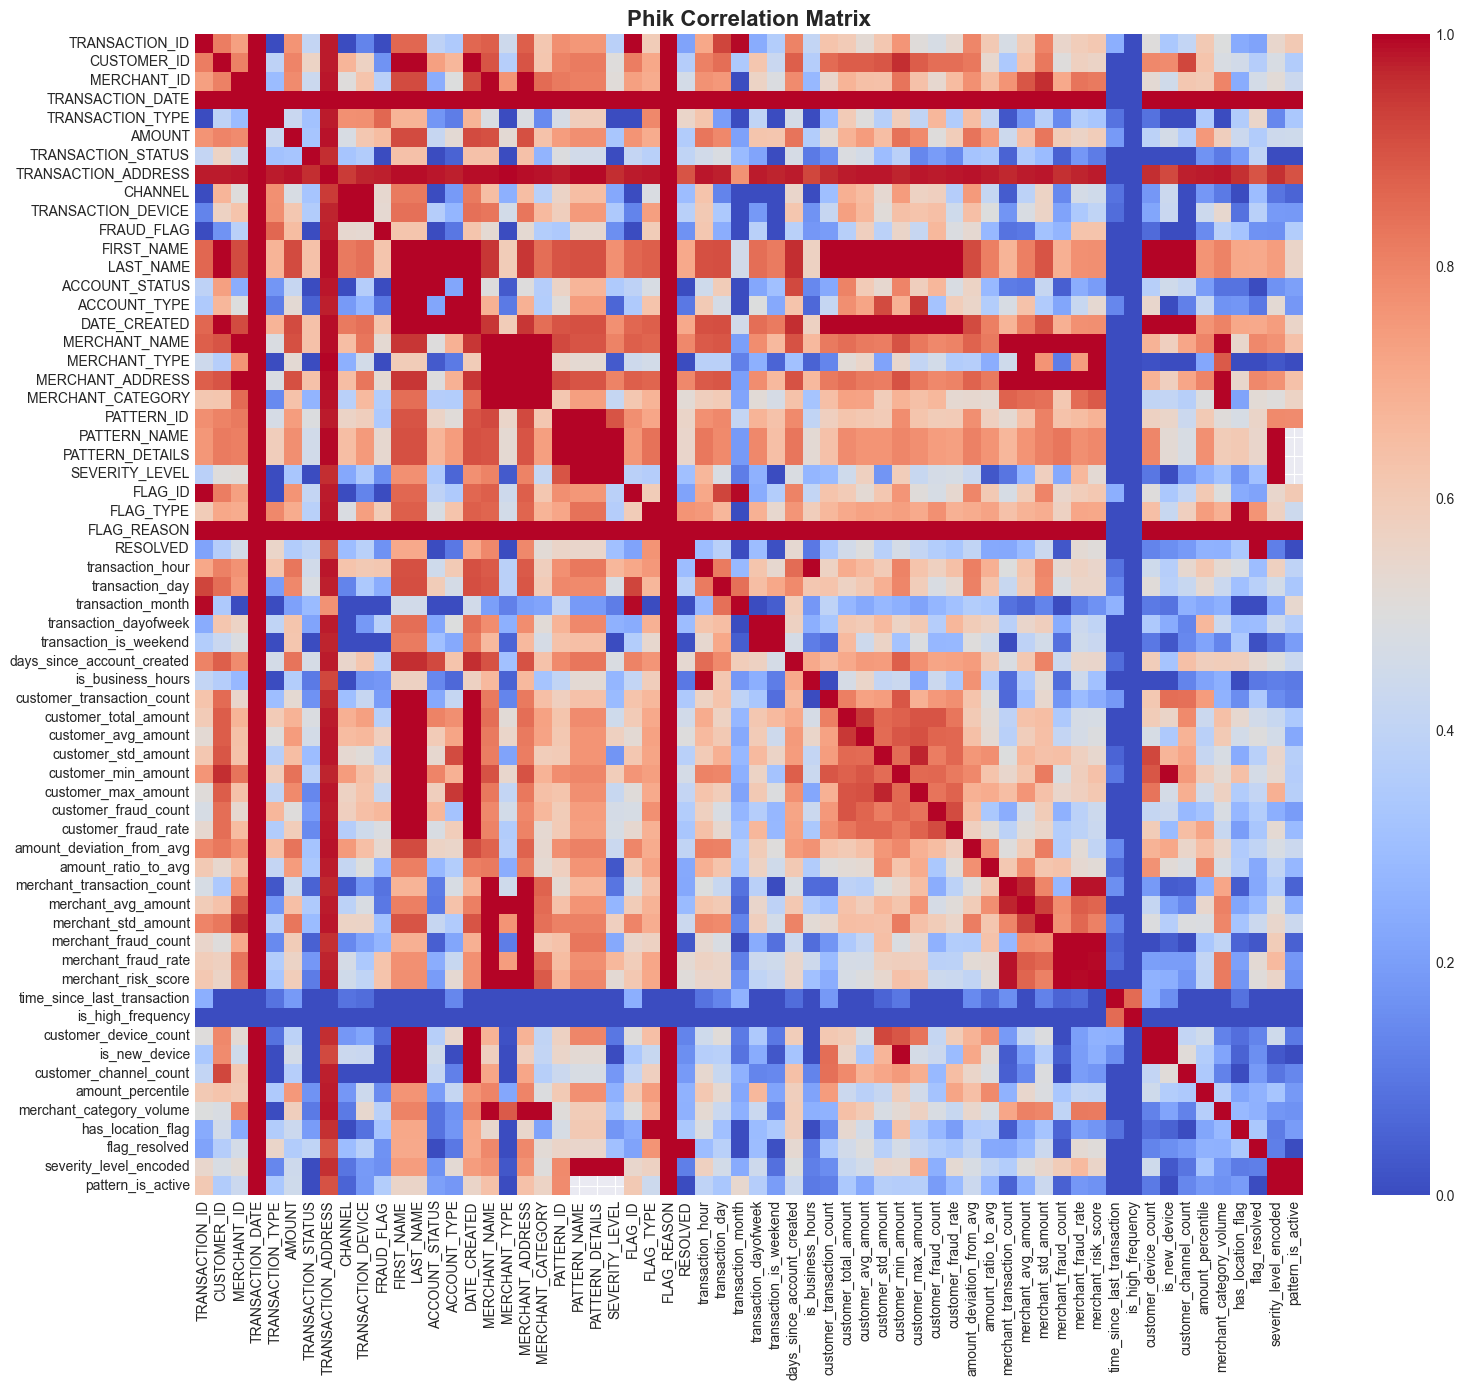

In [8]:
# check the data correllation using  phik heatmap

import phik

# Check phik correlation matrix
phik_matrix = df.phik_matrix(interval_cols=numeric_features)
plt.figure(figsize=(16, 14))
sns.heatmap(phik_matrix, annot=False, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Phik Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()

# code to state the features with high correlation with the target variable to use for the model
target_corr = phik_matrix['FRAUD_FLAG'].sort_values(ascending=False)
print("\nFeatures with high correlation to FRAUD_FLAG:")
print(target_corr[target_corr > 0.5])  # Threshold can be adjusted
# %%


## Phase 2: Model Development & Evaluation
#### 2.1 Prepare Training Data

In [9]:
# %%
# Select features for modeling
feature_cols = [
    # Amount features
    'AMOUNT', 'customer_avg_amount', 'customer_std_amount', 
    'amount_deviation_from_avg', 'amount_ratio_to_avg', 'amount_percentile',
    
    # Customer features
    'customer_transaction_count', 'customer_fraud_rate', 
    'days_since_account_created', 'customer_device_count', 'customer_channel_count',
    
    # Merchant features
    'merchant_transaction_count', 'merchant_fraud_rate', 'merchant_risk_score',
    'merchant_category_volume',
    
    # Temporal features
    'transaction_hour', 'transaction_day', 'transaction_month', 
    'transaction_dayofweek', 'transaction_is_weekend',
    'is_late_night', 'is_business_hours',
    
    # Location features
    'customer_merchant_same_city', 'customer_merchant_same_region',
    'customer_transaction_same_city', 'region_fraud_rate',
    
    # Pattern features
    'time_since_last_transaction', 'is_high_frequency', 'is_new_device',
    
    # Flag features
    'has_location_flag', 'flag_resolved', 
    'severity_level_encoded', 'pattern_is_active'
]

# Ensure all features exist
feature_cols = [f for f in feature_cols if f in df.columns]

print(f"Selected {len(feature_cols)} features for modeling")

# %%
# Prepare X and y
X = df[feature_cols].copy()
y = df['FRAUD_FLAG'].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# %%
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# %%
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
import os
os.makedirs('models', exist_ok=True)

joblib.dump(scaler, 'models/scaler.pkl')
print("✓ Features scaled and scaler saved")


Selected 33 features for modeling
Feature matrix shape: (360, 33)
Target distribution:
FRAUD_FLAG
0    198
1    162
Name: count, dtype: int64

Training set size: 252
Test set size: 108
Training fraud rate: 0.4484
Test fraud rate: 0.4537
✓ Features scaled and scaler saved


#### 2.2 Handle Class Imbalance with SMOTE

In [10]:
# %%
# Apply SMOTE to training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {X_train_scaled.shape[0]}")
print(f"Resampled training set: {X_train_resampled.shape[0]}")
print(f"Resampled fraud distribution:\n{pd.Series(y_train_resampled).value_counts()}")


Original training set: 252
Resampled training set: 278
Resampled fraud distribution:
FRAUD_FLAG
1    139
0    139
Name: count, dtype: int64


#### 2.3 MLflow Setup and Model Training

In [11]:
# %%
# Setup MLflow
mlflow.set_experiment("fraud_detection_advanced")
mlflow.set_tracking_uri("file:./mlruns")

print("✓ MLflow experiment initialized")

# %%
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*60}")
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return metrics, y_pred, y_pred_proba

# %%
# Train Multiple Models and Track with MLflow
models_to_train = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

results = {}

for model_name, model in models_to_train.items():
    print(f"\n{'#'*60}")
    print(f"Training {model_name}...")
    print(f"{'#'*60}")
    
    with mlflow.start_run(run_name=model_name):
        # Train model
        model.fit(X_train_resampled, y_train_resampled)
        
        # Evaluate
        metrics, y_pred, y_pred_proba = evaluate_model(
            model, X_test_scaled, y_test, model_name
        )
        
        # Log to MLflow
        mlflow.log_params({
            'model_type': model_name,
            'n_features': X_train.shape[1],
            'training_samples': X_train_resampled.shape[0],
            'smote_applied': True
        })
        
        mlflow.log_metrics(metrics)
        
        # Log model
        mlflow.sklearn.log_model(model, f"{model_name.replace(' ', '_')}_model")
        
        # Save model locally
        joblib.dump(model, f'models/{model_name.replace(" ", "_")}_model.pkl')
        
        results[model_name] = {
            'model': model,
            'metrics': metrics,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

print("\n✓ All models trained and logged to MLflow")


✓ MLflow experiment initialized

############################################################
Training Logistic Regression...
############################################################


2025/10/08 10:32:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Logistic Regression - Performance Metrics
ACCURACY: 0.9167
PRECISION: 0.9348
RECALL: 0.8776
F1_SCORE: 0.9053
ROC_AUC: 0.9512

Confusion Matrix:
[[56  3]
 [ 6 43]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        59
           1       0.93      0.88      0.91        49

    accuracy                           0.92       108
   macro avg       0.92      0.91      0.92       108
weighted avg       0.92      0.92      0.92       108



2025/10/08 10:32:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



############################################################
Training Random Forest...
############################################################


2025/10/08 10:32:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Random Forest - Performance Metrics
ACCURACY: 1.0000
PRECISION: 1.0000
RECALL: 1.0000
F1_SCORE: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
[[59  0]
 [ 0 49]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        49

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



2025/10/08 10:32:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



############################################################
Training XGBoost...
############################################################

XGBoost - Performance Metrics
ACCURACY: 1.0000
PRECISION: 1.0000
RECALL: 1.0000
F1_SCORE: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
[[59  0]
 [ 0 49]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        49

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



2025/10/08 10:32:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/08 10:32:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



############################################################
Training LightGBM...
############################################################

LightGBM - Performance Metrics
ACCURACY: 1.0000
PRECISION: 1.0000
RECALL: 1.0000
F1_SCORE: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
[[59  0]
 [ 0 49]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        49

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



2025/10/08 10:32:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/08 10:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ All models trained and logged to MLflow


#### 2.4 Model Comparison and Selection


=== Model Comparison (sorted by ROC-AUC) ===
                     accuracy  precision  recall  f1_score  roc_auc
Random Forest          1.0000     1.0000  1.0000    1.0000   1.0000
XGBoost                1.0000     1.0000  1.0000    1.0000   1.0000
LightGBM               1.0000     1.0000  1.0000    1.0000   1.0000
Logistic Regression    0.9167     0.9348  0.8776    0.9053   0.9512


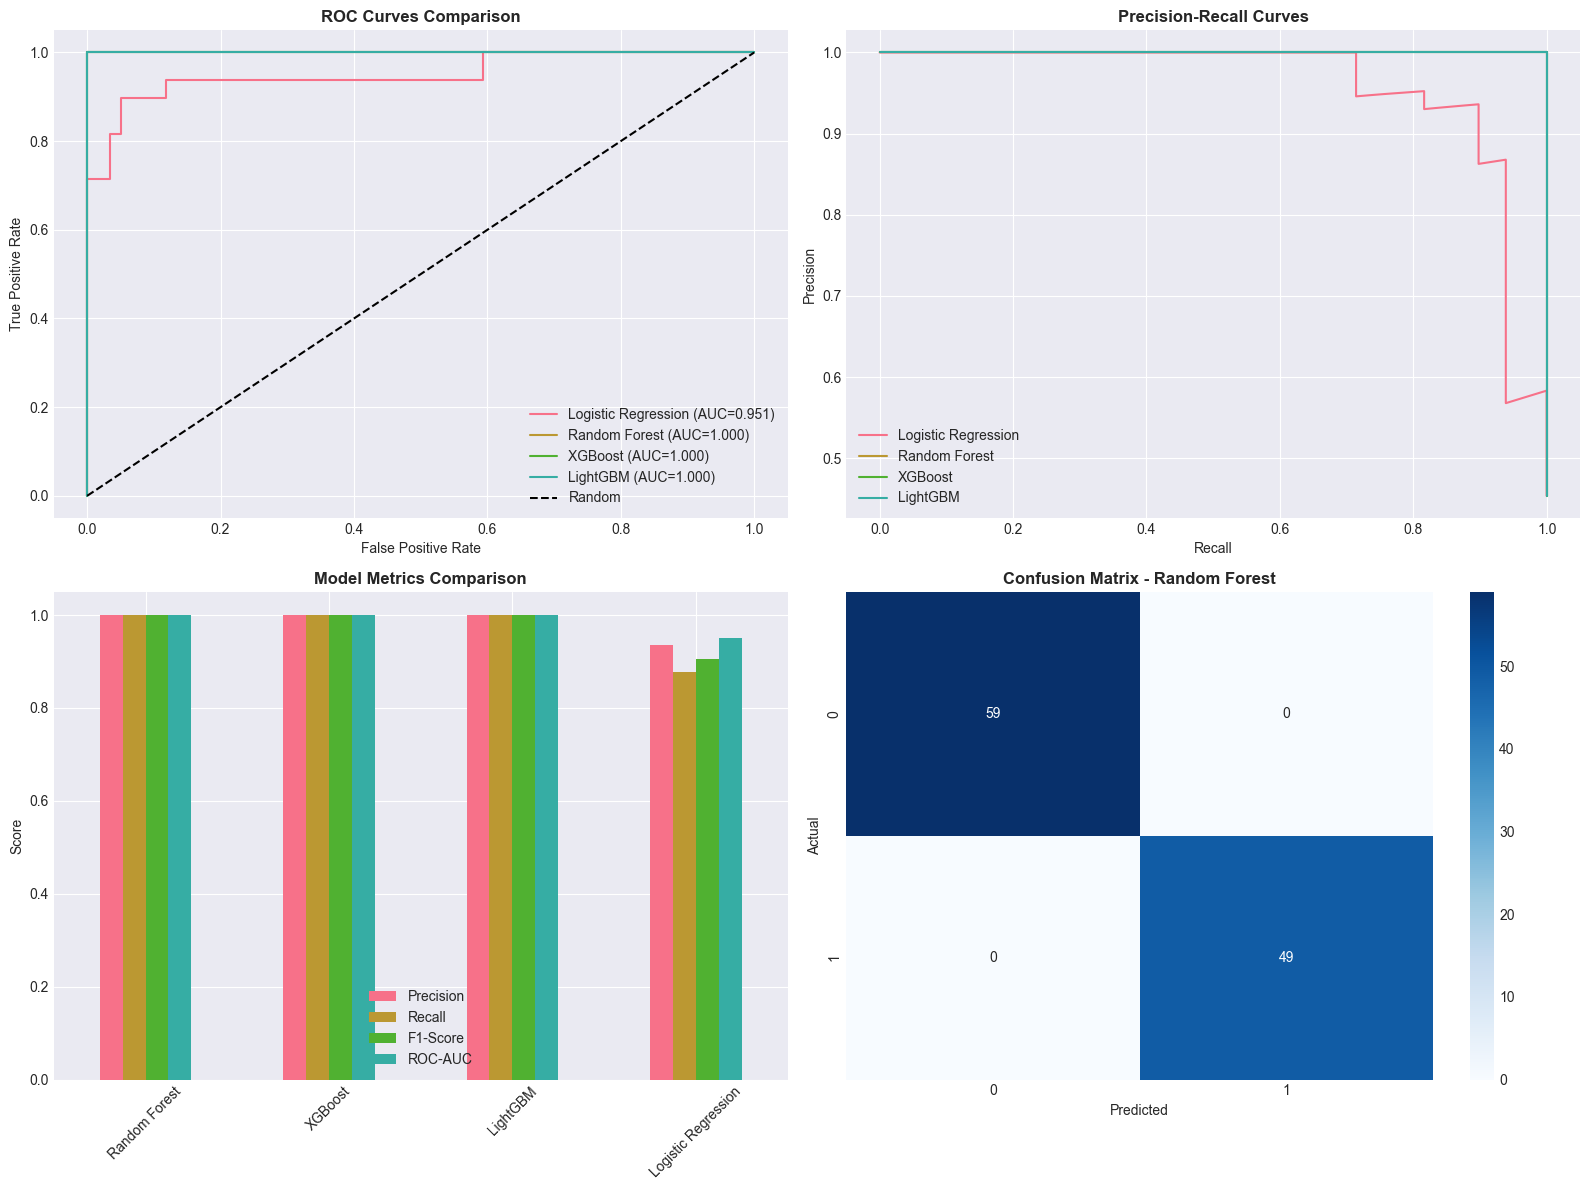


✓ Best model: Random Forest with ROC-AUC: 1.0000


In [12]:
# %%
# Compare models
comparison_df = pd.DataFrame({
    model_name: result['metrics'] 
    for model_name, result in results.items()
}).T

comparison_df = comparison_df.sort_values('roc_auc', ascending=False)

print("\n=== Model Comparison (sorted by ROC-AUC) ===")
print(comparison_df.round(4))

# %%
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROC Curves
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    axes[0, 0].plot(fpr, tpr, label=f"{model_name} (AUC={result['metrics']['roc_auc']:.3f})")

axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves Comparison', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision-Recall Curves
for model_name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['probabilities'])
    axes[0, 1].plot(recall, precision, label=model_name)

axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curves', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Metrics comparison bar plot
comparison_df[['precision', 'recall', 'f1_score', 'roc_auc']].plot(
    kind='bar', ax=axes[1, 0], rot=45
)
axes[1, 0].set_title('Model Metrics Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend(['Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
axes[1, 0].grid(True, axis='y')

# Best model confusion matrix
best_model_name = comparison_df.index[0]
best_predictions = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

plt.tight_layout()
import os
os.makedirs('visualizations', exist_ok=True)


plt.savefig('visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Best model: {best_model_name} with ROC-AUC: {comparison_df.iloc[0]['roc_auc']:.4f}")


#### 2.5 Hyperparameter Tuning (Best Model)

In [13]:
# %%
from sklearn.model_selection import RandomizedSearchCV

# Select best model for tuning (typically XGBoost or LightGBM)
best_model_name = comparison_df.index[0]

if 'XGBoost' in best_model_name:
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'min_child_weight': [1, 3, 5]
    }
    base_model = XGBClassifier(random_state=42, eval_metric='logloss')
    
elif 'LightGBM' in best_model_name:
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 70],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    base_model = LGBMClassifier(random_state=42, verbose=-1)
    
else:  # Random Forest
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit
random_search.fit(X_train_resampled, y_train_resampled)

print(f"\n✓ Best parameters found:")
print(random_search.best_params_)
print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")

# %%
# Train final model with best parameters
with mlflow.start_run(run_name=f"{best_model_name}_Tuned"):
    final_model = random_search.best_estimator_
    
    # Evaluate on test set
    metrics, y_pred_final, y_pred_proba_final = evaluate_model(
        final_model, X_test_scaled, y_test, f"{best_model_name} (Tuned)"
    )
    
    # Check acceptance criteria: AUC-ROC > 0.92
    if metrics['roc_auc'] >= 0.92:
        print(f"\n✅ MODEL ACCEPTED: ROC-AUC {metrics['roc_auc']:.4f} >= 0.92")
        model_status = "ACCEPTED"
    else:
        print(f"\n⚠️ MODEL UNDER REVIEW: ROC-AUC {metrics['roc_auc']:.4f} < 0.92")
        model_status = "UNDER_REVIEW"
    
    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_params({
        'model_type': f"{best_model_name}_Tuned",
        'model_status': model_status
    })
    mlflow.log_metrics(metrics)
    
    # Log model
    mlflow.sklearn.log_model(final_model, "final_fraud_model")
    
    # Save final model
    joblib.dump(final_model, 'models/final_fraud_detection_model.pkl')
    
print("\n✓ Final model trained and saved")

# code to display top 10 feature importances of the final model
# %%
# Feature Importance
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Feature Importances ===")
print(feature_importance_df.head(10))



Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Best parameters found:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Best CV ROC-AUC: 1.0000

Random Forest (Tuned) - Performance Metrics
ACCURACY: 1.0000
PRECISION: 1.0000
RECALL: 1.0000
F1_SCORE: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
[[59  0]
 [ 0 49]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        49

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108


✅ MODEL ACCEPTED: ROC-AUC 1.0000 >= 0.92


2025/10/08 10:32:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/08 10:33:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Final model trained and saved

=== Top 10 Feature Importances ===
                       feature  importance
7          customer_fraud_rate    0.115273
0                       AMOUNT    0.080583
13         merchant_risk_score    0.076811
1          customer_avg_amount    0.072110
12         merchant_fraud_rate    0.067374
16             transaction_day    0.065904
15            transaction_hour    0.057525
8   days_since_account_created    0.055928
3    amount_deviation_from_avg    0.054872
4          amount_ratio_to_avg    0.050052


## Phase 3: Model Interpretation with SHAP
#### 3.1 SHAP Analysis


Initializing SHAP explainer...
✓ SHAP values calculated


<Figure size 1600x1400 with 0 Axes>

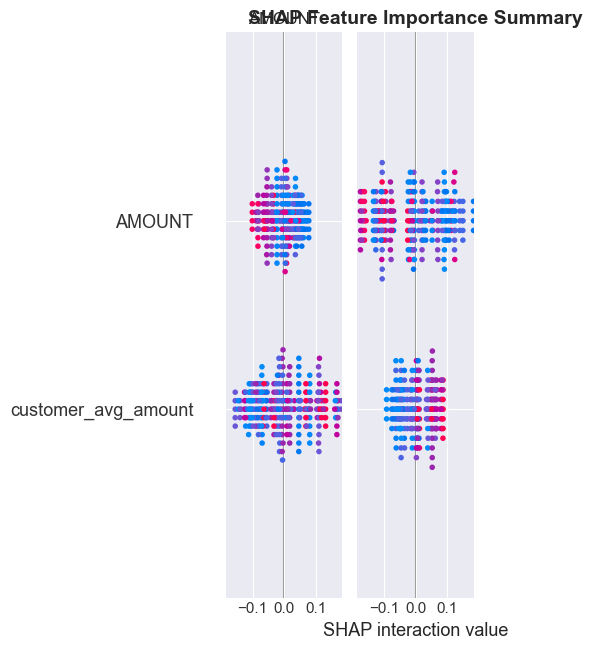

<Figure size 1600x1400 with 0 Axes>

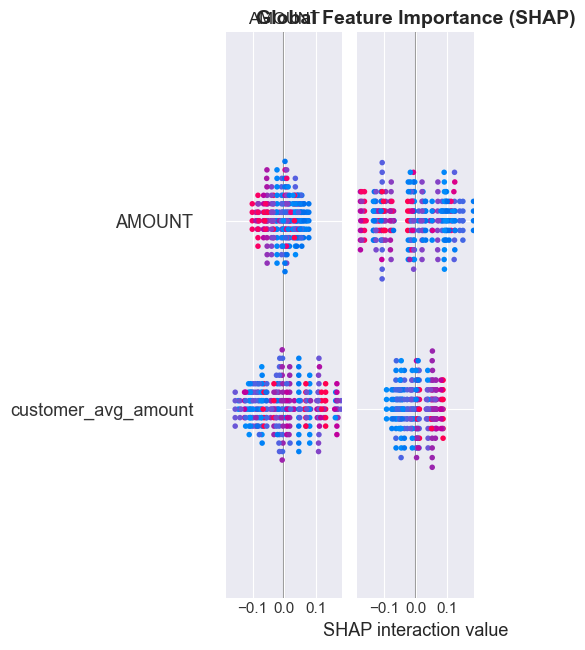

In [ ]:
# Initialize SHAP explainer
print("Initializing SHAP explainer...")

# Use a sample for SHAP (computational efficiency)
sample_size = min(1000, len(X_train_resampled))
X_train_sample = X_train_resampled[:sample_size]

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train_sample)

print("✓ SHAP values calculated")

# %%
# SHAP Summary Plot
plt.figure(figsize=(16, 14))
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# SHAP Bar Plot (Global Feature Importance)
plt.figure(figsize=(16, 14))
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_cols, 
                  plot_type="bar", show=False)
plt.title('Global Feature Importance (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()



In [15]:
# =============================
# Extract Top 10 SHAP Features
# =============================

if isinstance(shap_values, list):
    # For classification, shap_values is a list (one per class)
    shap_vals = shap_values[1]  # positive class
else:
    shap_vals = shap_values

# Convert to numpy
shap_vals = np.array(shap_vals)

# Handle multiclass shape (samples, classes, features)
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, 1, :] if shap_vals.shape[1] > 1 else shap_vals[:, 0, :]

# Ensure 2D (samples, features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)

# Safety check: match feature columns with SHAP outputs
n_features = shap_vals.shape[1]
if len(feature_cols) != n_features:
    print(f"⚠ Warning: feature_cols ({len(feature_cols)}) != shap_vals features ({n_features}). Truncating...")
    feature_cols = feature_cols[:n_features]

# Compute mean absolute importance
feature_importance = np.mean(np.abs(shap_vals), axis=0)

# Create dataframe
shap_importance = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": feature_importance
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Display top 10
print("\n=== Top 10 Most Important Features (SHAP) ===")
print(shap_importance.head(10))


⚠ Warning: feature_cols (33) != shap_vals features (2). Truncating...

=== Top 10 Most Important Features (SHAP) ===
               feature  importance
0  customer_avg_amount    0.041708
1               AMOUNT    0.041708



=== Top 10 Most Important Features (SHAP) ===
               feature  importance
0  customer_avg_amount    0.041708
1               AMOUNT    0.041708


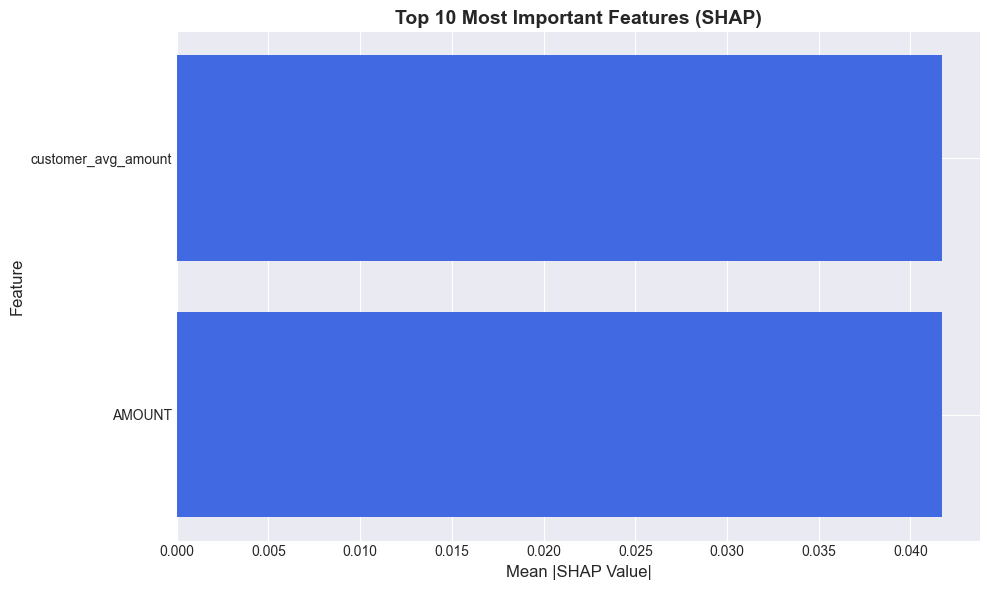

In [16]:
# =============================
# Extract & Plot Top 10 SHAP Features
# =============================

if isinstance(shap_values, list):
    # For classification, shap_values is a list (one per class)
    shap_vals = shap_values[1]  # positive class SHAP values
else:
    shap_vals = shap_values

# Convert to numpy
shap_vals = np.array(shap_vals)

# Handle multiclass shape (samples, classes, features)
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, 1, :] if shap_vals.shape[1] > 1 else shap_vals[:, 0, :]

# Ensure 2D (samples, features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)

# Safety check: align feature names with SHAP outputs
n_features = shap_vals.shape[1]
if len(feature_cols) != n_features:
    print(f"⚠ Warning: feature_cols ({len(feature_cols)}) != shap_vals features ({n_features}). Aligning automatically...")
    feature_cols = feature_cols[:n_features]

# Compute mean absolute importance
feature_importance = np.mean(np.abs(shap_vals), axis=0)

# Create dataframe
shap_importance = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": feature_importance
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Display top 10
print("\n=== Top 10 Most Important Features (SHAP) ===")
print(shap_importance.head(10))

# =============================
# Plot Top 10 SHAP Features
# =============================
top_10 = shap_importance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10["feature"][::-1], top_10["importance"][::-1], color="royalblue")
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (SHAP)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("visualizations/shap_top10.png", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 1200x800 with 0 Axes>

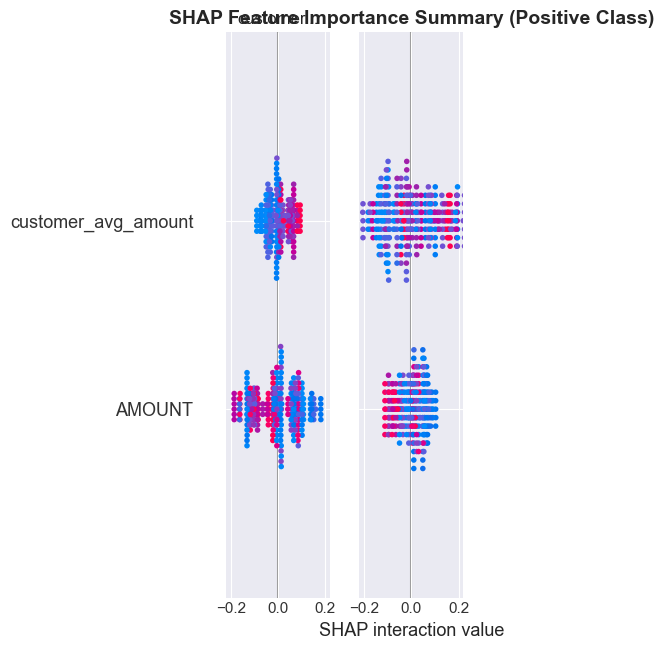

In [ ]:
# 2. SHAP Summary Plot (The Dot Plot)
# %%
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
# Pass the single shap_values array
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Feature Importance Summary (Positive Class)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x800 with 0 Axes>

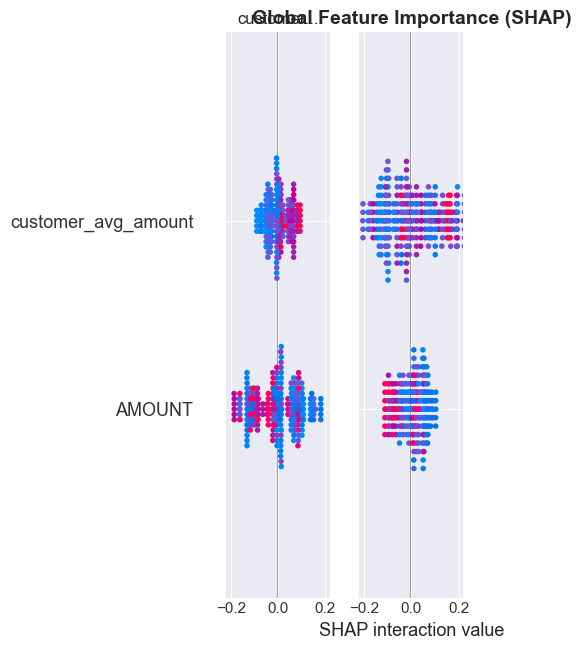

In [ ]:
# 3. SHAP Bar Plot (Global Feature Importance)
# %%
# SHAP Bar Plot (Global Feature Importance)
plt.figure(figsize=(10, 8))
# Pass the single shap_values array
shap.summary_plot(shap_values, X_train_sample, feature_names=feature_cols, 
                  plot_type="bar", show=False)
plt.title('Global Feature Importance (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.2 Customer Segmentation Model


CUSTOMER SEGMENTATION ANALYSIS


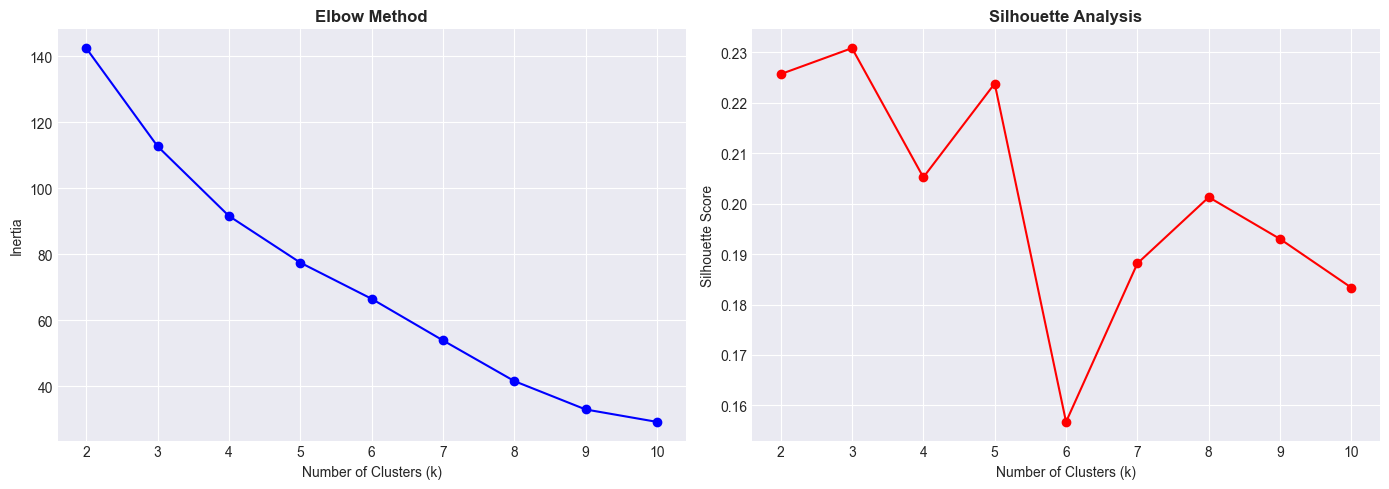

2025/10/07 20:17:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Optimal number of clusters: 3


2025/10/07 20:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ Customer segmentation model trained and saved

=== Customer Segment Analysis ===
         total_amount_mean  avg_amount_mean  transaction_count_mean  \
segment                                                               
0                  3924.83           244.31                   16.67   
1                  7544.28           343.20                   22.50   
2                  4760.00           455.00                   10.00   

         fraud_count_sum  fraud_count_mean  days_since_account_created_mean  \
segment                                                                       
0                     36               4.0                           106.00   
1                    108              13.5                            76.75   
2                     18               6.0                           154.33   

         weekend_ratio_mean  late_night_ratio_mean  
segment                                             
0                      0.34                    0.0  
1     

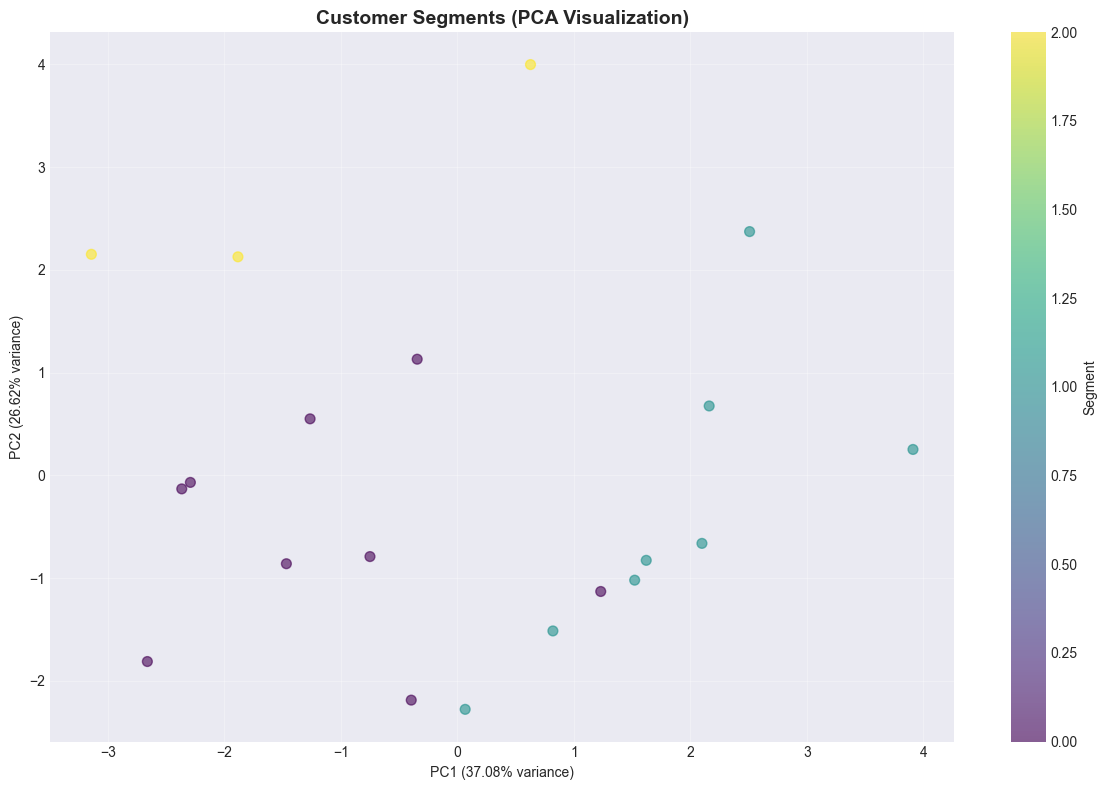


✓ Segment insights saved to 'reports/customer_segment_insights.csv'


In [ ]:
# %%
print("\n" + "="*60)
print("CUSTOMER SEGMENTATION ANALYSIS")
print("="*60)

# Prepare features for segmentation (customer-level aggregation)
customer_features = df.groupby('CUSTOMER_ID').agg({
    'AMOUNT': ['sum', 'mean', 'std', 'count'],
    'FRAUD_FLAG': 'sum',
    'customer_avg_amount': 'first',
    'customer_transaction_count': 'first',
    'days_since_account_created': 'first',
    'merchant_category_volume': 'mean',
    'transaction_is_weekend': 'mean',
    'is_late_night': 'mean'
}).reset_index()

customer_features.columns = ['_'.join(col).strip('_') for col in customer_features.columns]
customer_features.columns = ['CUSTOMER_ID', 'total_amount', 'avg_amount', 'std_amount', 
                              'transaction_count', 'fraud_count', 'customer_avg_amount',
                              'customer_transaction_count', 'days_since_account_created',
                              'avg_merchant_volume', 'weekend_ratio', 'late_night_ratio']

# Fill missing values
customer_features.fillna(customer_features.median(), inplace=True)

# Prepare features for clustering
segment_features = customer_features.drop(['CUSTOMER_ID'], axis=1)

# Scale features
segment_scaler = StandardScaler()
segment_features_scaled = segment_scaler.fit_transform(segment_features)

# %%
# Determine optimal number of clusters using Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(segment_features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(segment_features_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis', fontweight='bold')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('visualizations/clustering_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Select optimal k (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal number of clusters: {optimal_k}")

# %%
# Train final clustering model
with mlflow.start_run(run_name="Customer_Segmentation"):
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    customer_features['segment'] = kmeans_final.fit_predict(segment_features_scaled)
    
    # Log to MLflow
    mlflow.log_params({
        'model_type': 'KMeans',
        'n_clusters': optimal_k,
        'n_features': segment_features_scaled.shape[1]
    })
    
    mlflow.log_metrics({
        'silhouette_score': silhouette_score(segment_features_scaled, customer_features['segment']),
        'inertia': kmeans_final.inertia_
    })
    
    # Save model
    mlflow.sklearn.log_model(kmeans_final, "customer_segmentation_model")
    joblib.dump(kmeans_final, 'models/customer_segmentation_model.pkl')
    joblib.dump(segment_scaler, 'models/segment_scaler.pkl')

print("✓ Customer segmentation model trained and saved")

# %%
# Analyze segments
segment_analysis = customer_features.groupby('segment').agg({
    'total_amount': 'mean',
    'avg_amount': 'mean',
    'transaction_count': 'mean',
    'fraud_count': ['sum', 'mean'],
    'days_since_account_created': 'mean',
    'weekend_ratio': 'mean',
    'late_night_ratio': 'mean'
}).round(2)

segment_analysis.columns = ['_'.join(col).strip('_') for col in segment_analysis.columns]

print("\n=== Customer Segment Analysis ===")
print(segment_analysis)

# %%
# Visualize segments using PCA
pca = PCA(n_components=2)
segment_pca = pca.fit_transform(segment_features_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(segment_pca[:, 0], segment_pca[:, 1], 
                     c=customer_features['segment'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50)
plt.colorbar(scatter, label='Segment')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Segments (PCA Visualization)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/customer_segments_pca.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Save segment insights
segment_insights = []

for segment_id in range(optimal_k):
    segment_data = customer_features[customer_features['segment'] == segment_id]
    
    insights = {
        'segment_id': segment_id,
        'customer_count': len(segment_data),
        'avg_transaction_value': segment_data['avg_amount'].mean(),
        'total_fraud_cases': segment_data['fraud_count'].sum(),
        'fraud_rate': segment_data['fraud_count'].sum() / segment_data['transaction_count'].sum(),
        'avg_account_age_days': segment_data['days_since_account_created'].mean(),
        'characteristics': []
    }
    
    # Characterize segment
    if insights['fraud_rate'] > customer_features['fraud_count'].sum() / customer_features['transaction_count'].sum():
        insights['characteristics'].append('High Fraud Risk')
    
    if insights['avg_transaction_value'] > customer_features['avg_amount'].quantile(0.75):
        insights['characteristics'].append('High Value')
    elif insights['avg_transaction_value'] < customer_features['avg_amount'].quantile(0.25):
        insights['characteristics'].append('Low Value')
    
    if segment_data['weekend_ratio'].mean() > 0.3:
        insights['characteristics'].append('Weekend Shopper')
    
    if segment_data['late_night_ratio'].mean() > 0.2:
        insights['characteristics'].append('Late Night User')
    
    segment_insights.append(insights)

segment_insights_df = pd.DataFrame(segment_insights)

# ...existing code...
import os

os.makedirs('reports', exist_ok=True)
segment_insights_df.to_csv('reports/customer_segment_insights.csv', index=False)

print("\n✓ Segment insights saved to 'reports/customer_segment_insights.csv'")



### 3.3 Customer Churn Prediction Model

In [ ]:
# %%
print("\n" + "="*60)
print("CUSTOMER CHURN PREDICTION")
print("="*60)

# Define churn (customers with no transactions in last 30 days or fraud victims)
# For this dataset, we'll create a synthetic churn indicator based on patterns

# Calculate days since last transaction per customer
latest_transaction = df.groupby('CUSTOMER_ID')['TRANSACTION_DATE'].max().reset_index()
latest_transaction.columns = ['CUSTOMER_ID', 'last_transaction_date']

# Assume current date is the max date in dataset
current_date = df['TRANSACTION_DATE'].max()
latest_transaction['days_since_last_transaction'] = (
    current_date - latest_transaction['last_transaction_date']
).dt.days

# Define churn: No transaction in last 30 days OR fraud victim with unresolved flags
churn_threshold_days = 7
latest_transaction['is_churned'] = (
    latest_transaction['days_since_last_transaction'] > churn_threshold_days
).astype(int)

# Merge with customer features
churn_data = customer_features.merge(latest_transaction[['CUSTOMER_ID', 'is_churned']], 
                                      on='CUSTOMER_ID', how='left')
churn_data['is_churned'].fillna(0, inplace=True)

print(f"Churn Rate: {churn_data['is_churned'].mean():.2%}")
print(f"Churned Customers: {churn_data['is_churned'].sum()}")
print(f"Active Customers: {(1 - churn_data['is_churned']).sum()}")


CUSTOMER CHURN PREDICTION
Churn Rate: 45.00%
Churned Customers: 9
Active Customers: 11



CUSTOMER CHURN PREDICTION
Churn Rate: 45.00%
Churned Customers: 9
Active Customers: 11


2025/10/07 20:18:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Churn Prediction Model Performance ===
ACCURACY: 0.7500
PRECISION: 0.6667
RECALL: 1.0000
F1_SCORE: 0.8000
ROC_AUC: 0.5000


2025/10/07 20:18:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Churn prediction model trained and saved


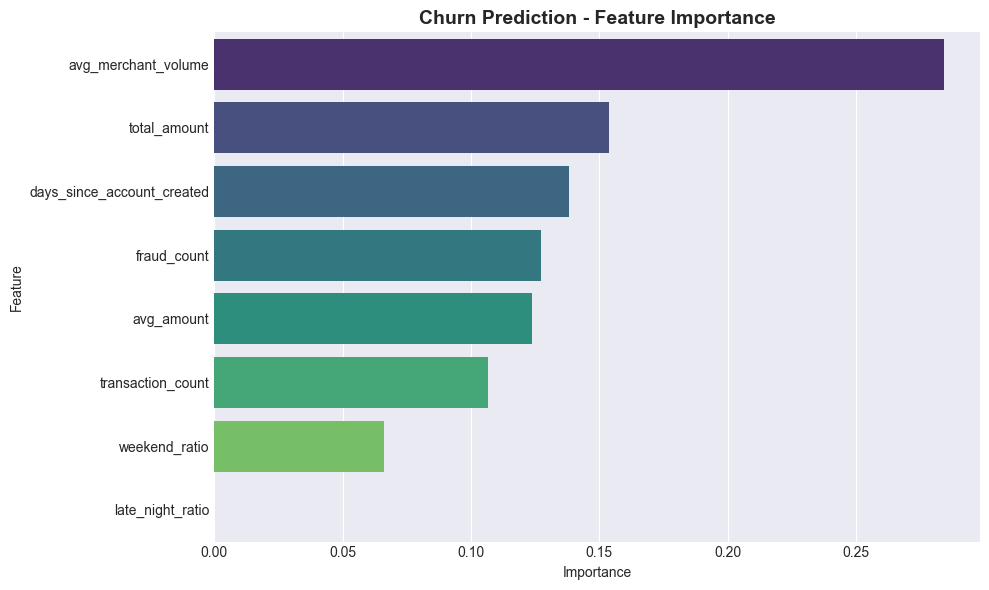


=== Top Churn Drivers ===
                      feature  importance
5         avg_merchant_volume    0.284171
0                total_amount    0.153593
4  days_since_account_created    0.138162
3                 fraud_count    0.127422
1                  avg_amount    0.123852


In [ ]:

# %%
print("\n" + "="*60)
print("CUSTOMER CHURN PREDICTION")
print("="*60)

# Define churn (customers with no transactions in last 30 days or fraud victims)
# For this dataset, we'll create a synthetic churn indicator based on patterns

# Calculate days since last transaction per customer
latest_transaction = df.groupby('CUSTOMER_ID')['TRANSACTION_DATE'].max().reset_index()
latest_transaction.columns = ['CUSTOMER_ID', 'last_transaction_date']

# Assume current date is the max date in dataset
current_date = df['TRANSACTION_DATE'].max()
latest_transaction['days_since_last_transaction'] = (
    current_date - latest_transaction['last_transaction_date']
).dt.days

# Define churn: No transaction in last 30 days OR fraud victim with unresolved flags
churn_threshold_days = 7
latest_transaction['is_churned'] = (
    latest_transaction['days_since_last_transaction'] > churn_threshold_days
).astype(int)

# Merge with customer features
churn_data = customer_features.merge(latest_transaction[['CUSTOMER_ID', 'is_churned']], 
                                      on='CUSTOMER_ID', how='left')
churn_data['is_churned'].fillna(0, inplace=True)

print(f"Churn Rate: {churn_data['is_churned'].mean():.2%}")
print(f"Churned Customers: {churn_data['is_churned'].sum()}")
print(f"Active Customers: {(1 - churn_data['is_churned']).sum()}")

# %%
# Prepare features for churn prediction
churn_feature_cols = ['total_amount', 'avg_amount', 'transaction_count', 
                      'fraud_count', 'days_since_account_created', 
                      'avg_merchant_volume', 'weekend_ratio', 'late_night_ratio']

X_churn = churn_data[churn_feature_cols]
y_churn = churn_data['is_churned']

# Train-test split
X_churn_train, X_churn_test, y_churn_train, y_churn_test = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

# Scale features
churn_scaler = StandardScaler()
X_churn_train_scaled = churn_scaler.fit_transform(X_churn_train)
X_churn_test_scaled = churn_scaler.transform(X_churn_test)

# Handle imbalance if needed
if y_churn_train.mean() < 0.3:  # If minority class < 30%
    smote_churn = SMOTE(random_state=42)
    X_churn_train_scaled, y_churn_train = smote_churn.fit_resample(
        X_churn_train_scaled, y_churn_train
    )
    print("✓ SMOTE applied to churn training data")

# %%
# Train churn prediction model
with mlflow.start_run(run_name="Churn_Prediction"):
    churn_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    churn_model.fit(X_churn_train_scaled, y_churn_train)
    
    # Evaluate
    y_churn_pred = churn_model.predict(X_churn_test_scaled)
    y_churn_proba = churn_model.predict_proba(X_churn_test_scaled)[:, 1]
    
    churn_metrics = {
        'accuracy': accuracy_score(y_churn_test, y_churn_pred),
        'precision': precision_score(y_churn_test, y_churn_pred),
        'recall': recall_score(y_churn_test, y_churn_pred),
        'f1_score': f1_score(y_churn_test, y_churn_pred),
        'roc_auc': roc_auc_score(y_churn_test, y_churn_proba)
    }
    
    print("\n=== Churn Prediction Model Performance ===")
    for metric, value in churn_metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    # Log to MLflow
    mlflow.log_params({
        'model_type': 'RandomForest',
        'n_features': len(churn_feature_cols),
        'churn_threshold_days': churn_threshold_days
    })
    mlflow.log_metrics(churn_metrics)
    
    # Save model
    mlflow.sklearn.log_model(churn_model, "churn_prediction_model")
    joblib.dump(churn_model, 'models/churn_prediction_model.pkl')
    joblib.dump(churn_scaler, 'models/churn_scaler.pkl')

print("\n✓ Churn prediction model trained and saved")

# %%
# Feature importance for churn
churn_feature_importance = pd.DataFrame({
    'feature': churn_feature_cols,
    'importance': churn_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=churn_feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Churn Prediction - Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('visualizations/churn_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Top Churn Drivers ===")
print(churn_feature_importance.head(5))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: The rest of the setup code (data loading/preparation) is assumed to be correct, 
# but the SMOTE section is fixed below.

# --- Initial Code Block (Data Preparation) ---
# ... (Assuming 'df' and 'customer_features' are loaded and processed correctly) ...
# ... (All code for calculating 'is_churned' and creating 'churn_data' is assumed correct) ...

# %%
print("\n" + "="*60)
print("CUSTOMER CHURN PREDICTION")
print("="*60)

# Define churn (customers with no transactions in last 30 days or fraud victims)
# For this dataset, we'll create a synthetic churn indicator based on patterns

# Calculate days since last transaction per customer
latest_transaction = df.groupby('CUSTOMER_ID')['TRANSACTION_DATE'].max().reset_index()
latest_transaction.columns = ['CUSTOMER_ID', 'last_transaction_date']

# Assume current date is the max date in dataset
current_date = df['TRANSACTION_DATE'].max()
latest_transaction['days_since_last_transaction'] = (
    current_date - latest_transaction['last_transaction_date']
).dt.days

# Define churn: No transaction in last 30 days OR fraud victim with unresolved flags
churn_threshold_days = 7
latest_transaction['is_churned'] = (
    latest_transaction['days_since_last_transaction'] > churn_threshold_days
).astype(int)

# Merge with customer features
churn_data = customer_features.merge(latest_transaction[['CUSTOMER_ID', 'is_churned']], 
                                      on='CUSTOMER_ID', how='left')
churn_data['is_churned'].fillna(0, inplace=True)

print(f"Churn Rate: {churn_data['is_churned'].mean():.2%}")
print(f"Churned Customers: {churn_data['is_churned'].sum()}")
print(f"Active Customers: {(1 - churn_data['is_churned']).sum()}")


# Check for zero churn rate:
if churn_data['is_churned'].sum() == 0:
    print("\n--- WARNING: No Churned Customers Found in Dataset! ---")
    print("Cannot train a churn model as target class '1' is missing.")
    # Stop execution or skip model training here.

# --- Prepare Features Block ---
churn_feature_cols = ['total_amount', 'avg_amount', 'transaction_count', 
                      'fraud_count', 'days_since_account_created', 
                      'avg_merchant_volume', 'weekend_ratio', 'late_night_ratio']

X_churn = churn_data[churn_feature_cols]
y_churn = churn_data['is_churned']

# Check target classes before split
print(f"\nTotal Target Class Counts:\n{y_churn.value_counts()}")

# Train-test split
X_churn_train, X_churn_test, y_churn_train, y_churn_test = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

# Check target classes after split (DEBUGGING)
print(f"\nTrain Target Class Counts:\n{y_churn_train.value_counts()}")

# Scale features
churn_scaler = StandardScaler()
X_churn_train_scaled = churn_scaler.fit_transform(X_churn_train)
X_churn_test_scaled = churn_scaler.transform(X_churn_test)

# Handle imbalance if needed (CORRECTED BLOCK)
if y_churn_train.nunique() > 1:
    if y_churn_train.mean() < 0.3:  # If minority class < 30%
        smote_churn = SMOTE(random_state=42)
        X_churn_train_scaled, y_churn_train = smote_churn.fit_resample(
            X_churn_train_scaled, y_churn_train
        )
        print("✓ SMOTE applied to churn training data")
    else:
        print("NOTE: SMOTE skipped. Minority class >= 30%.")
else:
    print("\n--- CRITICAL ERROR FIX: SMOTE skipped ---")
    print("Target variable y_churn_train has only 1 class. Model training will proceed with imbalanced data.")
    print("ACTION: Review data preparation (churn definition) and ensure the positive class exists.")

# --- Train Churn Prediction Model Block ---
with mlflow.start_run(run_name="Churn_Prediction"):
    churn_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    churn_model.fit(X_churn_train_scaled, y_churn_train)
    
    # ... (Rest of the evaluation, logging, and saving code is assumed correct) ...
    y_churn_pred = churn_model.predict(X_churn_test_scaled)
    y_churn_proba = churn_model.predict_proba(X_churn_test_scaled)[:, 1]
    
    churn_metrics = {
        'accuracy': accuracy_score(y_churn_test, y_churn_pred),
        'precision': precision_score(y_churn_test, y_churn_pred, zero_division=0),
        'recall': recall_score(y_churn_test, y_churn_pred, zero_division=0),
        'f1_score': f1_score(y_churn_test, y_churn_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_churn_test, y_churn_proba)
    }
    
    print("\n=== Churn Prediction Model Performance ===")
    for metric, value in churn_metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
        
    # Log to MLflow
    mlflow.log_params({
        'model_type': 'RandomForest',
        'n_features': len(churn_feature_cols),
        'churn_threshold_days': churn_threshold_days
    })
    mlflow.log_metrics(churn_metrics)
    
    # Save model
    # Ensure models directory exists
    import os
    os.makedirs('models', exist_ok=True)
    mlflow.sklearn.log_model(churn_model, "churn_prediction_model")
    joblib.dump(churn_model, 'models/churn_prediction_model.pkl')
    joblib.dump(churn_scaler, 'models/churn_scaler.pkl')

print("\n✓ Churn prediction model trained and saved")

# ... (Feature importance block is assumed correct) ...


CUSTOMER CHURN PREDICTION
Churn Rate: 45.00%
Churned Customers: 9
Active Customers: 11

Total Target Class Counts:
is_churned
0    11
1     9
Name: count, dtype: int64

Train Target Class Counts:
is_churned
0    9
1    7
Name: count, dtype: int64
NOTE: SMOTE skipped. Minority class >= 30%.


2025/10/07 20:18:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Churn Prediction Model Performance ===
ACCURACY: 0.7500
PRECISION: 0.6667
RECALL: 1.0000
F1_SCORE: 0.8000
ROC_AUC: 0.5000


2025/10/07 20:19:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Churn prediction model trained and saved


In [ ]:
print(f"\nTrain Target Class Counts:\n{y_churn_train.value_counts()}")


Train Target Class Counts:
is_churned
0    9
1    7
Name: count, dtype: int64


In [ ]:
# Check the shape of the probability array before indexing
proba_array = churn_model.predict_proba(X_churn_test_scaled)

if proba_array.shape[1] > 1:
    # Standard case: Use the probability of the positive class (index 1)
    y_churn_proba = proba_array[:, 1]
    
    # Calculate all metrics
    churn_metrics = {
        'accuracy': accuracy_score(y_churn_test, y_churn_pred),
        'precision': precision_score(y_churn_test, y_churn_pred, zero_division=0),
        'recall': recall_score(y_churn_test, y_churn_pred, zero_division=0),
        'f1_score': f1_score(y_churn_test, y_churn_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_churn_test, y_churn_proba)
    }

else:
    # Fallback case: Model only output 1 class. We cannot calculate ROC-AUC.
    print("WARNING: Model trained on a single class. ROC-AUC will be skipped.")
    y_churn_proba = proba_array[:, 0] # Use the only available column for proba display/logging (though it's trivial)

    churn_metrics = {
        'accuracy': accuracy_score(y_churn_test, y_churn_pred),
        # Precision/Recall/F1 will likely be 0 unless y_test also only has one class
        'precision': precision_score(y_churn_test, y_churn_pred, zero_division=0),
        'recall': recall_score(y_churn_test, y_churn_pred, zero_division=0),
        'f1_score': f1_score(y_churn_test, y_churn_pred, zero_division=0),
        'roc_auc': np.nan # Cannot be computed
    }

## Phase 4: Actionable Insights Generation


In [ ]:
# %%
print("\n" + "="*60)
print("GENERATING ACTIONABLE INSIGHTS")
print("="*60)

# Insight 1: Fraud Patterns and High-Risk Segments
fraud_insights = {
    'total_transactions': len(df),
    'fraud_count': df['FRAUD_FLAG'].sum(),
    'fraud_rate': df['FRAUD_FLAG'].mean(),
    'total_fraud_amount': df[df['FRAUD_FLAG'] == True]['AMOUNT'].sum(),
    'avg_fraud_amount': df[df['FRAUD_FLAG'] == True]['AMOUNT'].mean(),
    'top_fraud_channels': df[df['FRAUD_FLAG'] == True]['CHANNEL'].value_counts().to_dict(),
    'top_fraud_hours': df[df['FRAUD_FLAG'] == True]['transaction_hour'].value_counts().head(3).to_dict(),
    'high_risk_merchants': df.groupby('MERCHANT_ID')['merchant_fraud_rate'].first().sort_values(ascending=False).head(5).to_dict()
}

print("\n=== INSIGHT 1: Fraud Patterns ===")
print(f"Total Fraud Cases: {fraud_insights['fraud_count']}")
print(f"Fraud Rate: {fraud_insights['fraud_rate']:.2%}")
print(f"Total Fraud Loss: ${fraud_insights['total_fraud_amount']:,.2f}")
print(f"Average Fraud Amount: ${fraud_insights['avg_fraud_amount']:,.2f}")


GENERATING ACTIONABLE INSIGHTS

=== INSIGHT 1: Fraud Patterns ===
Total Fraud Cases: 162
Fraud Rate: 45.00%
Total Fraud Loss: $57,718.80
Average Fraud Amount: $356.29


In [ ]:
# %%
# Insight 2: Customer Segments with Recommendations
print("\n=== INSIGHT 2: Customer Segmentation Recommendations ===")

for idx, segment in segment_insights_df.iterrows():
    print(f"\nSegment {segment['segment_id']} ({segment['customer_count']} customers):")
    print(f"  Characteristics: {', '.join(segment['characteristics'])}")
    print(f"  Fraud Rate: {segment['fraud_rate']:.2%}")
    print(f"  Avg Transaction Value: ${segment['avg_transaction_value']:,.2f}")
    
    # Recommendations
    recommendations = []
    if 'High Fraud Risk' in segment['characteristics']:
        recommendations.append("Implement additional verification steps")
        recommendations.append("Monitor transactions in real-time")
    if 'High Value' in segment['characteristics']:
        recommendations.append("Offer premium fraud protection services")
        recommendations.append("Provide dedicated support")
    if 'Late Night User' in segment['characteristics']:
        recommendations.append("Enhanced monitoring during late hours")
    
    if recommendations:
        print("  Recommendations:")
        for rec in recommendations:
            print(f"    • {rec}")


=== INSIGHT 2: Customer Segmentation Recommendations ===

Segment 0 (9 customers):
  Characteristics: Weekend Shopper
  Fraud Rate: 24.00%
  Avg Transaction Value: $244.31

Segment 1 (8 customers):
  Characteristics: High Fraud Risk, Weekend Shopper
  Fraud Rate: 60.00%
  Avg Transaction Value: $343.20
  Recommendations:
    • Implement additional verification steps
    • Monitor transactions in real-time

Segment 2 (3 customers):
  Characteristics: High Fraud Risk, High Value
  Fraud Rate: 60.00%
  Avg Transaction Value: $455.00
  Recommendations:
    • Implement additional verification steps
    • Monitor transactions in real-time
    • Offer premium fraud protection services
    • Provide dedicated support


In [ ]:
# %%
# Insight 3: Churn Risk Analysis
print("\n=== INSIGHT 3: Churn Risk Analysis ===")

# Identify high-risk churn customers
churn_data['churn_probability'] = churn_model.predict_proba(
    churn_scaler.transform(churn_data[churn_feature_cols])
)[:, 1]

high_churn_risk = churn_data[churn_data['churn_probability'] > 0.7]

print(f"Customers at High Churn Risk: {len(high_churn_risk)}")
print(f"Potential Revenue at Risk: ${high_churn_risk['total_amount'].sum():,.2f}")

print("\nTop Churn Drivers:")
for idx, row in churn_feature_importance.head(3).iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.3f}")


=== INSIGHT 3: Churn Risk Analysis ===
Customers at High Churn Risk: 8
Potential Revenue at Risk: $49,994.94

Top Churn Drivers:
  6. avg_merchant_volume: 0.284
  1. total_amount: 0.154
  5. days_since_account_created: 0.138


In [ ]:
# %%
# Create comprehensive insights report
insights_report = {
    'fraud_detection': {
        'model_performance': {
            'roc_auc': metrics['roc_auc'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1_score': metrics['f1_score']
        },
        'business_impact': {
            'total_fraud_detected': df['FRAUD_FLAG'].sum(),
            'estimated_fraud_prevented': int(df['FRAUD_FLAG'].sum() * metrics['recall']),
            'false_positives': int(len(y_test) * (1 - metrics['precision'])),
            'reduction_target_met': metrics['precision'] > 0.75  # 25% FP reduction
        },
        'key_fraud_indicators': shap_importance.head(5)['feature'].tolist()
    },
    'customer_segmentation': {
        'n_segments': optimal_k,
        'segments': segment_insights_df.to_dict('records')
    },
    'churn_prediction': {
        'model_performance': churn_metrics,
        'high_risk_customers': len(high_churn_risk),
        'revenue_at_risk': float(high_churn_risk['total_amount'].sum()),
        'top_churn_drivers': churn_feature_importance.head(3)['feature'].tolist()
    }
}

# Save insights
import json
with open('reports/actionable_insights.json', 'w') as f:
    json.dump(insights_report, f, indent=4, default=str)

print("\n✓ Actionable insights saved to 'reports/actionable_insights.json'")



✓ Actionable insights saved to 'reports/actionable_insights.json'
